In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Generate Double Moon Data
## Usage: data = dbmoon(N, d, r, w)
</br> The data set contains two regions A and B representing 2 classes
</br> each region is a half ring with radius r = 10, width = 6, one is upper half and the other is lower half
</br></br> d: distance between the two regions
</br> will generate region A centered at (0, 0) and region B is a mirror image of region A (w.r.t.x axis) with a (r, d) shift of origin
</br></br> N:  # of samples each class, default = 1000
</br> d: seperation of two class, negative value means overlapping (default=1)
</br> r: radius (default=10), w: width of ring (default=6)

In [2]:
def dbmoon(N=1000, d=1, r=10, w=6):
    # generate region A:
    # first generate a uniformly random distributed data points from (-r-w / 2, 0)
    # to (r+w / 2, r+w / 2) 
    N1 = 10 * N  # generate more points and select those meet criteria
    w2 = w / 2
    done = 0
    tmp1 = np.array([[]])
    while not done:
        tmp = np.array(2 * (r + w2) * (np.random.uniform(0, 1, (N1, 1)) - 0.5))
        tmp = np.column_stack((tmp, (r + w2) * np.random.uniform(0, 1, (N1, 1))))
        # 3rd column of tmp is the magnitude of each data point
        thirdCol = np.sqrt(np.multiply(tmp[:, 0], tmp[:, 0]) + np.multiply(tmp[:, 1], tmp[:, 1]))
        tmp = np.column_stack((tmp, thirdCol.T))
        idx = np.nonzero(np.logical_and((tmp[:, 2] > (r - w2)), (tmp[:, 2] < (r + w2))))
        if tmp1.shape == (1,0):
            tmp1 = tmp[:, 0:2][idx]
        else:
            tmp1 = np.row_stack((tmp1, tmp[:, 0:2][idx]))
        if len(idx[0]) >= N:
            done = 1
            # if not enough data point, generate more and test

    # region A data and class label 0
    # region B data is region A data flip y coordinate - d, and x coordinate +r
    data = np.column_stack((tmp1[0:N, :], np.zeros((N, 1))))
    data1 = np.column_stack(((tmp1[0:N, 0] + r), (-tmp1[0:N, 1] - d), np.ones((N, 1))))
    data = np.row_stack((data, data1))
    return data

# Plot the double moon data

In [3]:
def plot(data, target, mu):
    idx = np.nonzero(target)
    plt.plot(data[idx, 0], data[idx, 1], 'b.')
    idx = np.where(target == 0)
    plt.plot(data[idx, 0], data[idx, 1], 'r.')
    plt.plot(mu[:, 0], mu[:, 1], 'gs')
    plt.show()

# Initialize Clusters Centers using K-Means method

In [4]:
def k_means(data_in, k, threshold):
    indices = random.sample(range(len(data_in)), k)
    mu = np.array([data_in[i] for i in sorted(indices)])
    old_cost = 0
    while True:
        distances = {}
        for i in range(k):
            distances[i] = np.sqrt(np.sum(((data_in[:]-mu[i])**2), axis=1))
        
        clusters = {}
        for i in range(k):
            clusters[i] = mu[i]
            for x in range(len(data_in)):
                mini = distances[i][x]
                mini_index = i
                for j in range(k):
                    if j == i:
                        continue
                    if mini > distances[j][x]:
                        mini = distances[j][x]
                        mini_index = j
                if mini_index == i:
                    clusters[i] = np.row_stack((clusters[i], data_in[x, :]))
            clusters[i] = clusters[i][1:, :]    
            mu[i] = np.mean(clusters[i], axis=0)
        # cost calculation
        
        cost = 0
        for i in range(k):
            cost += np.sqrt(np.sum(((clusters[i][:] - mu[i]) ** 2)))

        if abs(cost - old_cost) <= threshold:
            break
        old_cost = cost
                
    return mu

In [16]:
def init_segma(data):
    den = np.sqrt(2 * len(data[:, 0]))
    
    distances = data[:, 0]
    for i in range(len(data[:, 0])):
        col = np.sqrt(np.sum(((data[:] - data[i, :]) ** 2), axis=1))
        distances = np.column_stack((distances, col))
    distances = distances[:, 1:]
    segma = np.max(distances)**2 / den
    
    return segma

In [6]:
def cost(target, output):
    return 0.5 * np.sum((target - output)**2)

In [7]:
def batch_update(training_data, training_labels, weights, mu, segma):
    dEdW = np.zeros(weights.shape)
    dEdMu = np.zeros(mu.shape)
    dEdSegma = np.zeros(segma.shape)
    for i in range(len(training_data)):
        training_sample = training_data[i, :]
        training_label = training_labels[i]
        
        net = np.sum((training_sample - mu)**2, axis=1)
        act = np.exp(-net / (2 * segma ** 2))
        output = np.dot(act, weights)
        
        dEdy = np.subtract(training_label, output)
        
        dEdW += np.multiply([dEdy], act).T
        
        dnetdmu = (training_sample - mu)
        dEdnet = np.multiply([dEdy], act).T * weights / segma**2
        dEdMu += dEdnet * dnetdmu
        
        dEdact = dEdy * weights
        dEdSegma += np.sum(dEdact * np.multiply([net], [act]).T)/segma**3
    
    return dEdW, dEdMu, dEdSegma

In [8]:
def error(data, labels, weights, mu, segma):
    error = 0
    for i in range(len(data)):
        net = np.sum((data[i, :] - mu)**2, axis=1)
        act = np.exp(-net / (2 * segma ** 2))
        output = np.dot(act, weights)
        error += cost(labels[i], output)

    return error/len(data) * 100

In [13]:
def train_RBF_NN(training_data, training_labels, k=4, k_means_threshold=0, iterations=200):
    # number of input units = 2    (2 input dimensions)
    # number of hidden units = k
    # number of outut units = 1    (2 classes: class 0 & class 1)

    # mu initialization
    mu = k_means(training_data, k, k_means_threshold)

    # segma initialization
    segma = init_segma(training_data)

    # weights initialization
    weights = np.random.rand(k, 1)

    #print "initial mu:\n", mu, "\n"
    #print "initial segma:\n", segma, "\n"
    #print "initial weights:,\n", weights, "\n"
    #plot(training_data, training_labels, mu)
    
    # backpropagation 
    for j in range(iterations):
        dEdW, dEdMu, dEdSegma = batch_update(training_data, training_labels, weights, mu, segma) 
        weights += 0.1*dEdW/len(training_data)
        mu += 0.1*dEdMu/len(training_data)
        segma += 0.1*dEdSegma/len(training_data)
        
    return weights, mu, segma

In [14]:
data = dbmoon(1000)
training_data = data[:, 0:2]
training_labels = data[:, 2:3]


print "at k = 2:\n"

weights_2, mu_2, segma_2 = train_RBF_NN(training_data, training_labels, k=2)
training_error_2 = error(training_data, training_labels, weights_2, mu_2, segma_2)
print "training error at k = 2:", training_error_2, "%"

print "at k = 4:\n"

weights_4, mu_4, segma_4 = train_RBF_NN(training_data, training_labels, k=4)
training_error_4 = error(training_data, training_labels, weights_4, mu_4, segma_4)
print "training error at k = 4:", training_error_4, "%"

print "at k = 6:\n"

weights_6, mu_6, segma_6 = train_RBF_NN(training_data, training_labels, k=6)
training_error_6 = error(training_data, training_labels, weights_6, mu_6, segma_6)
print "training error at k = 6:", training_error_6, "%"

print "at k = 8:\n"

weights_8, mu_8, segma_8 = train_RBF_NN(training_data, training_labels, k=8)
training_error_8 = error(training_data, training_labels, weights_8, mu_8, segma_8)
print "training error at k = 8:", training_error_8, "%"

print "at k = 10:\n"

weights_10, mu_10, segma_10 = train_RBF_NN(training_data, training_labels, k=10)
training_error_10 = error(training_data, training_labels, weights_10, mu_10, segma_10)
print "training error at k = 10: ", training_error_10, "%"

test = dbmoon(100)
testing_data = test[:, 0:2]
testing_labels = test[:, 2:3]

print "##########################################################################################"

test_error_2 = error(testing_data, testing_labels, weights_2, mu_2, segma_2)
print "test error at k = 2:", test_error_2, "%"

test_error_4 = error(testing_data, testing_labels, weights_4, mu_4, segma_4)
print "test error at k = 4:", test_error_4, "%"

test_error_6 = error(testing_data, testing_labels, weights_6, mu_6, segma_6)
print "test error at k = 6:", test_error_6, "%"

test_error_8 = error(testing_data, testing_labels, weights_8, mu_8, segma_8)
print "test error at k = 8:", test_error_8, "%"

test_error_10 = error(testing_data, testing_labels, weights_10, mu_10, segma_10)
print "test error at k = 10:", test_error_10, "%"

at k = 2:

35.9001636818
training error at k = 2: 4.76392453809 %
at k = 4:

35.9001636818
training error at k = 4: 3.63206811757 %
at k = 6:

35.9001636818
training error at k = 6: 2.55612430451 %
at k = 8:

35.9001636818
training error at k = 8: 3.0277019779 %
at k = 10:

35.9001636818
training error at k = 10:  2.60084945828 %
##########################################################################################
test error at k = 2: 4.97144283226 %
test error at k = 4: 3.81310133168 %
test error at k = 6: 2.64228099087 %
test error at k = 8: 3.20327576943 %
test error at k = 10: 2.67311949568 %


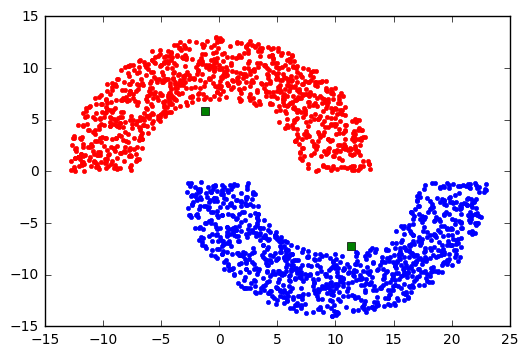

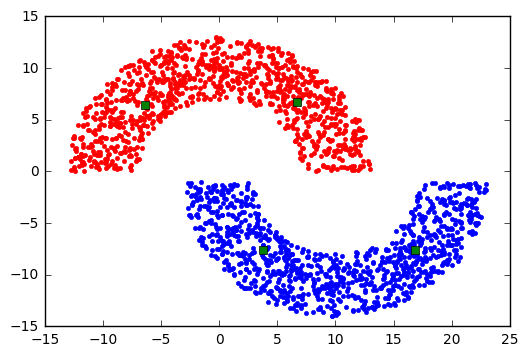

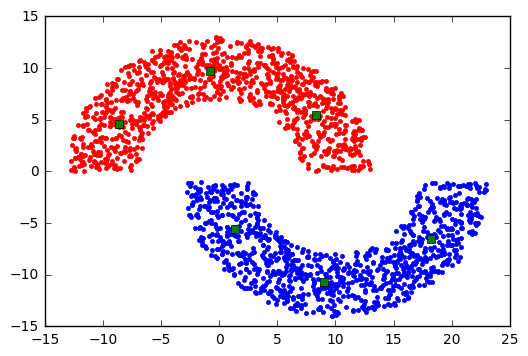

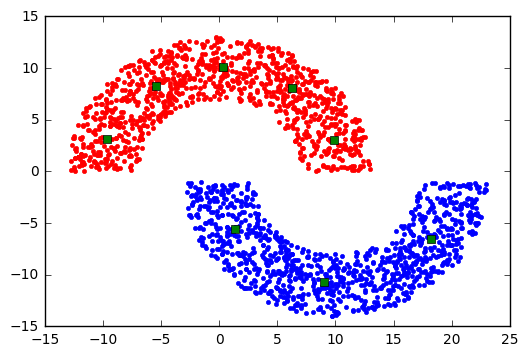

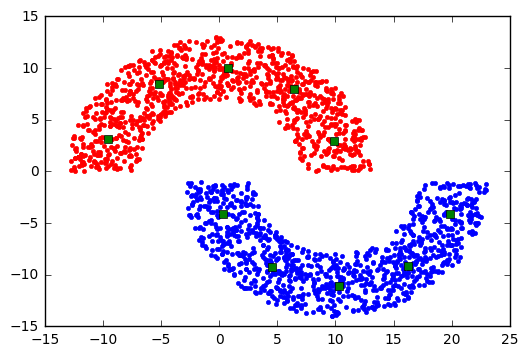

In [15]:
plot(training_data, training_labels, mu_2)
plot(training_data, training_labels, mu_4)
plot(training_data, training_labels, mu_6)
plot(training_data, training_labels, mu_8)
plot(training_data, training_labels, mu_10)